In [34]:
from os import listdir
import glob
import pandas as pd
import numpy as np
from datetime import datetime
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from pmdarima import auto_arima

In [43]:
def get_data_daily(f):
    filepaths = glob.glob("../data/tidy/" + f + "/*_events_*.csv")
    df = pd.concat(map(pd.read_csv, filepaths), sort=False)
    df["CLINICAL_EVENT_DATETIME"] = pd.to_datetime(df["CLINICAL_EVENT_DATETIME"])
    df.index = df["CLINICAL_EVENT_DATETIME"]
    df_monthly = df.resample("D").count()[["EVENT_ID"]]
    df_monthly.columns = ["Actual"]

    # remove current month
    df_monthly = df_monthly[df_monthly.index < datetime.now().strftime('%Y-%m-01')]
    return df_monthly


def get_actual_data(f):
    filepaths = glob.glob("../data/tidy/" + f + "/*_events_*.csv")
    df = pd.concat(map(pd.read_csv, filepaths), sort=False)
    df["CLINICAL_EVENT_DATETIME"] = pd.to_datetime(df["CLINICAL_EVENT_DATETIME"])
    df.index = df["CLINICAL_EVENT_DATETIME"]
    df_monthly = df.resample("MS").count()[["EVENT_ID"]]
    df_monthly.columns = ["Actual"]

    # remove current month
    df_monthly = df_monthly[df_monthly.index < datetime.now().strftime('%Y-%m-01')]
    return df_monthly

def arima_model(df):
    auto_mod = auto_arima(df["Actual"], suppress_warnings=True, seasonal=False, stepwise=False, error_action="ignore")
    auto_mod.summary()
    model_arima = ARIMA(df["Actual"], order=auto_mod.order)
    fit_arima = model_arima.fit()
    return fit_arima

def make_preds_df(fit, df, n=12, freq="MS"):
    fc, se, conf = fit.forecast(n, alpha=0.05)  # 95% conf
    idx = pd.date_range(df.index[-1] + pd.DateOffset(days=1), periods = n, freq=freq)
    fc_series = pd.Series(fc, index=idx)
    lower_series = pd.Series(conf[:, 0], index=idx)
    upper_series = pd.Series(conf[:, 1], index=idx)
    
    df_comb = pd.concat([fc_series.round(0), lower_series.round(0), upper_series.round(0)], axis=1)
    df_comb.index.name = "CLINICAL_EVENT_DATETIME"
    df_comb.columns = ["Forecast", "Lower", "Upper"]
    return df_comb

In [35]:
df_monthly = get_actual_data("acetaminophen")
df_daily = get_data_daily("acetaminophen")

In [42]:
df_daily

,Actual
CLINICAL_EVENT_DATETIME,
2016-07-01,123
2016-07-02,76
2016-07-03,52
2016-07-04,47
2016-07-05,88
2016-07-06,106
2016-07-07,133
2016-07-08,135
2016-07-09,103


In [38]:
auto_mod_daily = auto_arima(df_daily["Actual"], 
                            start_p=0,
                            start_q=0,
                            seasonal=False, 
                            stepwise=False,
                            error_action="ignore")
auto_mod_daily.summary()

/home/brian/miniconda3/envs/med_tracking/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/brian/miniconda3/envs/med_tracking/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 1094
Model:                 ARIMA(5, 1, 5)   Log Likelihood               -4572.405
Method:                       css-mle   S.D. of innovations             15.747
Date:                Sun, 07 Jul 2019   AIC                           9168.811
Time:                        15:47:48   BIC                           9228.782
Sample:                             1   HQIC                          9191.504
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0515      0.062     -0.827      0.408      -0.174       0.071
ar.L1.D.y      1.3935      0.033     42.323      0.000       1.329       1.458
ar.L2.D.y     -1.9174      0.027    -72.174      0.000      -1.969      -1.865
ar.L3.D.y      1.6535      0.047     34.839      0.000       1.561       1.747
ar.L4.D.y     -1.4692      0.026    -55.857      0.000      -1.521      -1.418
ar.L5.D.y      0.5905      0.033     18.117      0.000       0.527       0.654
ma.L1.D.y     -1.7346      0.020    -85.027      0.000      -1.775      -1.695
ma.L2.D.y      2.1271      0.028     75.408      0.000       2.072       2.182
ma.L3.D.y     -2.0640      0.034    -60.639      0.000      -2.131      -1.997
ma.L4.D.y      1.6304      0.028     58.180      0.000       1.576       1.685
ma.L5.D.y     -0.8624      0.018    -47.534      0.000      -0.898      -0.827
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.2227           -0.9761j            1.0012           -0.2857
AR.2           -0.2227           +0.9761j            1.0012            0.2857
AR.3            0.6235           -0.7828j            1.0008           -0.1430
AR.4            0.6235           +0.7828j            1.0008            0.1430
AR.5            1.6868           -0.0000j            1.6868           -0.0000
MA.1           -0.2261           -0.9962j            1.0215           -0.2855
MA.2           -0.2261           +0.9962j            1.0215            0.2855
MA.3            1.0586           -0.0000j            1.0586           -0.0000
MA.4            0.6421           -0.7984j            1.0246           -0.1422
MA.5            0.6421           +0.7984j            1.0246            0.1422
-----------------------------------------------------------------------------
"""

In [40]:
model_arima = ARIMA(df_daily["Actual"], order=auto_mod_daily.order)
fit_arima = model_arima.fit()

In [44]:
fcast_daily = make_preds_df(fit_arima, df_daily, 366, "D")
fcast_daily

,Forecast,Lower,Upper
CLINICAL_EVENT_DATETIME,,,
2019-07-01,46.0,15.0,77.0
2019-07-02,59.0,22.0,96.0
2019-07-03,62.0,23.0,101.0
2019-07-04,60.0,20.0,100.0
2019-07-05,53.0,13.0,93.0
2019-07-06,42.0,1.0,82.0
2019-07-07,38.0,-3.0,79.0
2019-07-08,49.0,8.0,90.0
2019-07-09,60.0,19.0,102.0


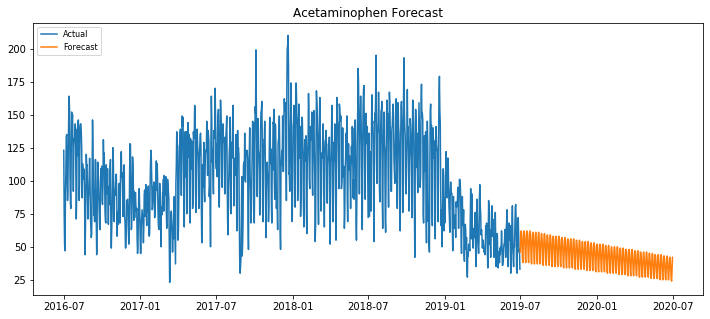

In [45]:
plt.figure(figsize=(12, 5))
plt.plot(df_daily, label='Actual')
plt.plot(fcast_daily["Forecast"], label='Forecast')
# plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=0.15)
plt.title('Acetaminophen Forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [32]:
auto_mod = auto_arima(df_monthly["Actual"], 
                      start_p=0,
                      start_q=0,
                      seasonal=False, 
                      stepwise=False, 
                      information_criterion="aicc",
#                       test="adf",
                      trace=True)
auto_mod.summary()

Fit ARIMA: order=(0, 1, 0); AIC=513.739, BIC=516.850, Fit time=0.004 seconds
Fit ARIMA: order=(0, 1, 1); AIC=515.729, BIC=520.395, Fit time=0.025 seconds
Fit ARIMA: order=(0, 1, 2); AIC=515.538, BIC=521.760, Fit time=0.132 seconds
Fit ARIMA: order=(0, 1, 3); AIC=517.402, BIC=525.178, Fit time=0.195 seconds
Fit ARIMA: order=(0, 1, 4); AIC=515.390, BIC=524.722, Fit time=0.240 seconds
Fit ARIMA: order=(0, 1, 5); AIC=517.357, BIC=528.244, Fit time=0.538 seconds
Fit ARIMA: order=(1, 1, 0); AIC=515.727, BIC=520.393, Fit time=0.077 seconds
Fit ARIMA: order=(1, 1, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 4); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 5); AIC=nan, BIC=nan, Fit time=nan seconds


/home/brian/miniconda3/envs/med_tracking/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(1, 1, 1); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/home/brian/miniconda3/envs/med_tracking/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(1, 1, 2); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/home/brian/miniconda3/envs/med_tracking/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(1, 1, 3); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/home/brian/miniconda3/envs/med_tracking/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:207: ModelFitWarning: Unable to 

Fit ARIMA: order=(2, 1, 0); AIC=517.339, BIC=523.561, Fit time=0.161 seconds
Fit ARIMA: order=(2, 1, 1); AIC=519.552, BIC=527.329, Fit time=0.199 seconds


/home/brian/miniconda3/envs/med_tracking/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(2, 1, 2); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/home/brian/miniconda3/envs/med_tracking/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(2, 1, 3); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/home/brian/miniconda3/envs/med_tracking/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(2, 1, 4); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/home/brian/miniconda3/envs/med_tracking/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:207: ModelFitWarning: Unable to 

Fit ARIMA: order=(2, 1, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 4); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 5); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(3, 1, 0); AIC=517.723, BIC=525.500, Fit time=0.149 seconds
Fit ARIMA: order=(3, 1, 1); AIC=518.286, BIC=527.618, Fit time=0.239 seconds


/home/brian/miniconda3/envs/med_tracking/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/brian/miniconda3/envs/med_tracking/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(3, 1, 3); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/home/brian/miniconda3/envs/med_tracking/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(3, 1, 4); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/home/brian/miniconda3/envs/med_tracking/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(3, 1, 5); data is likely non-stationary. (if y

Fit ARIMA: order=(3, 1, 2); AIC=509.367, BIC=520.255, Fit time=0.392 seconds
Fit ARIMA: order=(3, 1, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(3, 1, 4); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(3, 1, 5); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(4, 1, 0); AIC=515.971, BIC=525.303, Fit time=0.225 seconds
Fit ARIMA: order=(4, 1, 1); AIC=517.970, BIC=528.857, Fit time=0.271 seconds
Fit ARIMA: order=(4, 1, 2); AIC=nan, BIC=nan, Fit time=0.178 seconds


/home/brian/miniconda3/envs/med_tracking/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:693: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
/home/brian/miniconda3/envs/med_tracking/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:695: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/home/brian/miniconda3/envs/med_tracking/lib/python3.7/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in subtract
  **kwargs)).imag/2./hess[i, j]
/home/brian/miniconda3/envs/med_tracking/lib/python3.7/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in multiply
  **kwargs)).imag/2./hess[i, j]
/home/brian/miniconda3/envs/med_tracking/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-

Fit ARIMA: order=(4, 1, 3); AIC=nan, BIC=nan, Fit time=0.252 seconds
Fit ARIMA: order=(4, 1, 4); AIC=517.416, BIC=532.970, Fit time=1.601 seconds
Fit ARIMA: order=(4, 1, 5); AIC=nan, BIC=nan, Fit time=nan seconds


/home/brian/miniconda3/envs/med_tracking/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:207: ModelFitWarning: Unable to fit ARIMA for order=(4, 1, 5); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)


Fit ARIMA: order=(5, 1, 0); AIC=517.967, BIC=528.855, Fit time=0.358 seconds


/home/brian/miniconda3/envs/med_tracking/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:695: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/home/brian/miniconda3/envs/med_tracking/lib/python3.7/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in subtract
  **kwargs)).imag/2./hess[i, j]
/home/brian/miniconda3/envs/med_tracking/lib/python3.7/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in multiply
  **kwargs)).imag/2./hess[i, j]
/home/brian/miniconda3/envs/med_tracking/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/brian/miniconda3/envs/med_tracking/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


Fit ARIMA: order=(5, 1, 1); AIC=526.506, BIC=538.949, Fit time=0.414 seconds


/home/brian/miniconda3/envs/med_tracking/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:693: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
/home/brian/miniconda3/envs/med_tracking/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:695: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/home/brian/miniconda3/envs/med_tracking/lib/python3.7/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in subtract
  **kwargs)).imag/2./hess[i, j]
/home/brian/miniconda3/envs/med_tracking/lib/python3.7/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in multiply
  **kwargs)).imag/2./hess[i, j]
/home/brian/miniconda3/envs/med_tracking/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-

Fit ARIMA: order=(5, 1, 2); AIC=nan, BIC=nan, Fit time=0.403 seconds


/home/brian/miniconda3/envs/med_tracking/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:693: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
/home/brian/miniconda3/envs/med_tracking/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:695: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/home/brian/miniconda3/envs/med_tracking/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/brian/miniconda3/envs/med_tracking/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/brian/miniconda3/envs/med_tracking/lib/python3.7/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid va

Fit ARIMA: order=(5, 1, 3); AIC=nan, BIC=nan, Fit time=0.448 seconds


/home/brian/miniconda3/envs/med_tracking/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/brian/miniconda3/envs/med_tracking/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/brian/miniconda3/envs/med_tracking/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:693: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
/home/brian/miniconda3/envs/med_tracking/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:695: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/home/brian/miniconda3/envs/med_tracking/lib/python3.7/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value enco

Fit ARIMA: order=(5, 1, 4); AIC=nan, BIC=nan, Fit time=1.099 seconds
Fit ARIMA: order=(5, 1, 5); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 7.887 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                   35
Model:                 ARIMA(3, 1, 2)   Log Likelihood                -247.684
Method:                       css-mle   S.D. of innovations            265.563
Date:                Sun, 07 Jul 2019   AIC                            509.367
Time:                        02:20:34   BIC                            520.255
Sample:                             1   HQIC                           513.126
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -63.1674     72.891     -0.867      0.393    -206.031      79.696
ar.L1.D.y     -0.6227      0.174     -3.589      0.001      -0.963      -0.283
ar.L2.D.y     -0.4413      0.187     -2.362      0.025      -0.808      -0.075
ar.L3.D.y      0.3881      0.153      2.536      0.017       0.088       0.688
ma.L1.D.y      0.7782      0.150      5.203      0.000       0.485       1.071
ma.L2.D.y      1.0000      0.153      6.557      0.000       0.701       1.299
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.5878           -0.8768j            1.0556           -0.3440
AR.2           -0.5878           +0.8768j            1.0556            0.3440
AR.3            2.3128           -0.0000j            2.3128           -0.0000
MA.1           -0.3891           -0.9212j            1.0000           -0.3136
MA.2           -0.3891           +0.9212j            1.0000            0.3136
-----------------------------------------------------------------------------
"""

In [30]:
model_arima = ARIMA(df_monthly["Actual"], order=(3, 0, 3))
fit_arima = model_arima.fit()

/home/brian/miniconda3/envs/med_tracking/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [24]:
fcast = make_preds_df(fit_arima, df_monthly)
fcast

,Forecast,Lower,Upper
CLINICAL_EVENT_DATETIME,,,
2019-07-01,1551.0,1046.0,2055.0
2019-08-01,1685.0,927.0,2442.0
2019-09-01,2080.0,1009.0,3150.0
2019-10-01,2189.0,918.0,3460.0
2019-11-01,2382.0,1025.0,3740.0
2019-12-01,2679.0,1232.0,4125.0
2020-01-01,2696.0,1207.0,4184.0
2020-02-01,2810.0,1311.0,4310.0
2020-03-01,2972.0,1456.0,4488.0


In [23]:
mod2 = ARIMA(df_monthly["Actual"], order=(1, 0, 0))
fit2 = mod2.fit()

In [25]:
fcast2 = make_preds_df(fit2, df_monthly)
fcast2

,Forecast,Lower,Upper
CLINICAL_EVENT_DATETIME,,,
2019-07-01,1741.0,1058.0,2425.0
2019-08-01,1862.0,944.0,2780.0
2019-09-01,1970.0,900.0,3041.0
2019-10-01,2067.0,888.0,3247.0
2019-11-01,2155.0,895.0,3414.0
2019-12-01,2233.0,912.0,3554.0
2020-01-01,2303.0,934.0,3672.0
2020-02-01,2366.0,960.0,3772.0
2020-03-01,2423.0,988.0,3858.0


In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

,Forecast,Lower,Upper
CLINICAL_EVENT_DATETIME,,,
2019-07-01,1551.0,1046.0,2055.0
2019-08-01,1685.0,927.0,2442.0
2019-09-01,2080.0,1009.0,3150.0
2019-10-01,2189.0,918.0,3460.0
2019-11-01,2382.0,1025.0,3740.0
2019-12-01,2679.0,1232.0,4125.0
2020-01-01,2696.0,1207.0,4184.0
2020-02-01,2810.0,1311.0,4310.0
2020-03-01,2972.0,1456.0,4488.0
